# LSTMによる非線形歪補償
時系列データを考慮できるLSTMによる補償

In [31]:
#import
import sys
import time
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

sys.path.append('../')
from pyopt.util import save_pickle, load_pickle

# 1. Preprocessing

## 1.1 データの整形

In [2]:
def data_shaping1_1(input_signal, signal, max_tap, tap):
    """
    input_signal: 伝送前の信号
    signal: 伝送後の信号
    max_tap: 最大の同時入力シンボル数
    tap: 同時入力シンボル数
    
    signal = [x_0, x_1, ... , x_(n-1)]
      |
      |
      v
    x = [[x_0, x_1, ... , x_tap-1],
            [x_1, x_2, ..., x_tap],
                   .
                   .
                   .
            [x_(n-tap), x_(n-tap+1), ..., x(n-1)]]
      |
      |
      v
    x = [[i_0, q_0, i_1, q_1, ... , i_(tap-1), q_(tap-1)],
            [i_1, q_1, i_2, q_2, ... , i_tap, q_tap],
                   .
                   .
                   .
            [i_(n-tap), q_(n-tap), i_(n-tap+1), q_(n-tap+1), ..., i_(n-1), q_(n-1)]] (batch, input_dim) input_dim = tap * 2
    
    y  (batch, output_dim) output_dim = 2
    """
    
    x = np.zeros((len(input_signal) - (max_tap - 1), tap * 2), dtype=float)
    y = np.zeros((len(input_signal) - (max_tap - 1), 2), dtype=float)
    for i, j in enumerate(np.arange(max_tap // 2, len(input_signal) - max_tap // 2)):
        x[i, 0::2] = signal[j - tap // 2: j + tap // 2 + 1].real
        x[i, 1::2] = signal[j - tap // 2: j + tap // 2 + 1].imag
        y[i, 0] = input_signal[j].real
        y[i, 1] = input_signal[j].imag
    return x, y

In [3]:
def data_shaping1_2(input_signal, signal, max_tap, tap, feature_dim):
    """
    x: (batch, tap, feature_dim)
    y: (batch, tap, output_dim) output_dim = 2
    """
    
    x, y = data_shaping1_1(input_signal, signal, max_tap, max_tap)
    x = x[:x.shape[0] // tap * tap, x.shape[1] // 2 - feature_dim // 2: x.shape[1] // 2 + feature_dim // 2].reshape([-1, tap, feature_dim])
    y = y[:y.shape[0] // tap * tap].reshape([-1, tap, 2])
    return x, y[:, -1, :] # y.shape[1] // 2

In [4]:
def data_shaping2_1(input_signal, signal, max_tap, tap):
    """
    signal = [x_0, x_1, ... , x_(n-1)]
      |
      |
      v
    x = [[[i_0, q_0],
             [i_1, q_1],
              ... ,
             [i_(tap-1), q_(tap-1)]],
            [[i_1, q_1],
             [i_2, q_2],
              ... ,
             [i_tap, q_tap]],
                   .
                   .
                   .
            [[i_(n-tap), q_(n-tap)],
             [i_(n-tap+1), q_(n-tap+1)],
              ...,
             [i_(n-1), q_(n-1)]]] (batch, tap, 2)
    """
    
    x = np.zeros((len(input_signal) - (max_tap - 1), tap, 2), dtype=float)
    y = np.zeros((len(input_signal) - (max_tap - 1), 2), dtype=float)
    for i, j in enumerate(np.arange(max_tap // 2, len(input_signal) - max_tap // 2)):
        x[i, :, 0] = signal[j - max_tap // 2: j + max_tap // 2 + 1].real
        x[i, :, 1] = signal[j - max_tap // 2: j + max_tap // 2 + 1].imag
        y[i, 0] = input_signal[j].real
        y[i, 1] = input_signal[j].imag
    return x, y

In [5]:
def data_shaping2_2(input_signal, signal, max_tap, tap):
    """
    x = [[[i_0, q_0],
             [i_1, q_1],
              ... ,
             [i_(tap-1), q_(tap-1)]],
            [[i_1, q_1],
             [i_2, q_2],
              ... ,
             [i_tap, q_tap]],
                   .
                   .
                   .
            [[i_(n-tap), q_(n-tap)],
             [i_(n-tap+1), q_(n-tap+1)],
              ...,
             [i_(n-1), q_(n-1)]]] (batch, tap, 2)
      |
      |
      v
    x = [[[i_0, q_0                               , i_(tap-1), q_(tap-1)],
             [i_1, q_1                               , i_(tap-2), q_(tap-2)],
              ... ,
             [i_(tap//2), q_(tap//2)         , i_(tap//2), q_(tap//2)]],
            [[i_1, q_1                               , i_(tap), q_(tap)],
             [i_2, q_2                               , i_(tap-1), q_(tap-1)],
              ... ,
             [i_(tap//2+1), q_(tap//2+1), i_(tap//2+1), q_(tap//2+1)]],
                   .
                   .
                   .
            [[i_(n-tap), q_(n-tap)                          , i_(n-1), q_(n-1)],
             [i_(n-tap+1), q_(n-tap+1)                 , i_(n-2), q_(n-2)],
              ...,
             [i_(tap//2+n-tap), q_(tap//2+n-tap), i_(tap//2+n-tap), q_(tap//2+n-tap)]]] (batch, tap // 2 + 1, 2 * 2)
    """
    
    x, y = data_shaping2_1(input_signal, signal, max_tap, tap)
    x_flap = x[:, tap // 2:, :][:, ::-1, :]
    x = np.concatenate([x[:, :tap // 2 + 1, :], x_flap], axis=2)
    return x, y

In [6]:
#動作確認
tap = 9
max_tap = 501
feature_dim = 12

df_dir = '../data/input/prbs.csv'
df = pd.read_csv(df_dir, index_col=0)  # dataframe読み込み
condition = (df['N']==17) & (df['itr']==1) & (df['form']=='RZ16QAM') & (df['n']==32) & (df['equalize']==False) & (df['baudrate']==28) & (df['PdBm']==1)
sgnl = load_pickle(df[condition].iloc[0]['data_path'])  # dataframeから条件と合う行を取得し,pickleの保存先(data_path)にアクセス
lc = sgnl.linear_compensation(2500, sgnl.signal['x_2500'])
x, y = data_shaping1_2(sgnl.signal['x_0'][16::32], lc[16::32], max_tap, tap, feature_dim)  # ANNに入力できるようにデータを整形

print('x size: ', x.shape)
print('y size: ', y.shape)

x size:  (3585, 9, 12)
y size:  (3585, 2)


## 1.2 平均,標準偏差の計算

In [7]:
mean = np.mean(x)
std = np.std(x)

print('mean: ', mean)
print('std: ', std)

mean:  -281.17668252467587
std:  52526.25900330765


# 2. Dataset定義

In [8]:
class Dataset(data.Dataset):
    def __init__(self, x, y, mean, std):
        self.x, self.y, self.mean, self.std = x, y, mean, std
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        
        x = (x - self.mean) / self.std
        y = (y - self.mean) / self.std
        return torch.Tensor(x), torch.Tensor(y)

In [9]:
#動作確認
train_dataset = Dataset(x=x, y=y, mean=mean, std=std)

index = 0
x_normalized, y_normalized = train_dataset.__getitem__(index)
x_array = x_normalized.detach().numpy()

print('mean: ', np.mean(x_array))
print('std: ', np.std(x_array))
print(x_normalized)
print(y_normalized)

mean:  0.08038987
std:  1.0820999
tensor([[-0.0931,  0.0098,  0.5634,  0.7753, -0.1233,  0.7345, -0.1318, -1.8640,
          0.1648, -0.2791,  0.5514,  1.8445],
        [ 0.5634,  0.7753, -0.1233,  0.7345, -0.1318, -1.8640,  0.1648, -0.2791,
          0.5514,  1.8445, -0.0932,  0.0195],
        [-0.1233,  0.7345, -0.1318, -1.8640,  0.1648, -0.2791,  0.5514,  1.8445,
         -0.0932,  0.0195,  1.9178, -1.7945],
        [-0.1318, -1.8640,  0.1648, -0.2791,  0.5514,  1.8445, -0.0932,  0.0195,
          1.9178, -1.7945, -0.0781, -0.6790],
        [ 0.1648, -0.2791,  0.5514,  1.8445, -0.0932,  0.0195,  1.9178, -1.7945,
         -0.0781, -0.6790,  1.4516, -0.1519],
        [ 0.5514,  1.8445, -0.0932,  0.0195,  1.9178, -1.7945, -0.0781, -0.6790,
          1.4516, -0.1519, -1.9071,  0.6820],
        [-0.0932,  0.0195,  1.9178, -1.7945, -0.0781, -0.6790,  1.4516, -0.1519,
         -1.9071,  0.6820, -1.0198,  0.1255],
        [ 1.9178, -1.7945, -0.0781, -0.6790,  1.4516, -0.1519, -1.9071,  0.68

In [10]:
batch_size = 100

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dataloaders_dict = {'train': train_dataloader}

# 3. Model定義

In [11]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTM, self).__init__()
        self.rnn = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden0=None):
        x, (hidden, cell) = self.rnn(x, hidden0)
        x = self.fc(x[:, -1, :])  # int((x.shape[1] - 1) / 2)
        return x

In [12]:
#動作確認
hidden_dim = 100
device = torch.device('cpu') # 'cuda' if torch.cuda.is_available() else 
print('Device available now:', device)

model = LSTM(input_dim=12, hidden_dim=hidden_dim, output_dim=2).to(device)
for x, y in train_dataloader:
    output = model(x)
    print(output[:6])
    break

Device available now: cpu
tensor([[ 0.0616, -0.0534],
        [ 0.0857, -0.0092],
        [ 0.0580, -0.0424],
        [ 0.0588, -0.0390],
        [ 0.0661, -0.0465],
        [ 0.0775, -0.0100]], grad_fn=<SliceBackward>)


# 4. Train定義

In [13]:
def evm_score(y_true, y_pred):
    if y_true.ndim == 2:
        y_true = y_true[:, 0] + 1j * y_true[:, 1]
        y_pred = y_pred[:, 0] + 1j * y_pred[:, 1]
    tmp = 0
    for i in range(len(y_pred)):
        tmp += abs(y_pred[i] - y_true[i]) ** 2 / abs(y_true[i]) ** 2
    evm = torch.sqrt(tmp / len(y_pred)) * 100
    return evm

In [14]:
def train_model(device, model, dataloaders_dict, criterion, optimizer, epochs):
    for epoch in range(epochs):
        start_time = time.time()
        
        for phase in dataloaders_dict.keys():
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            epoch_loss = 0.0
            epoch_evms = 0.0
            
            for x, y in dataloaders_dict[phase]:
                x = x.to(device)
                y = y.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(x)
                    loss = criterion(outputs, y)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    epoch_loss += loss.item() * x.size(0)
                    epoch_evms = (evm_score(y, outputs) / 100) ** 2 * x.size(0)
            
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_evm = torch.sqrt(epoch_evms / len(dataloaders_dict[phase].dataset)) * 100
            
            duration = str(datetime.timedelta(seconds=time.time() - start_time))[:7]
            print('{} | Epoch: {}/{} | {} Loss: {:.4} | EVM: {:.4}'.format(duration, epoch + 1, epochs, phase, epoch_loss, epoch_evm))
    return model

In [15]:
#動作確認
epochs = 5
lr = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=lr)

train_model(device=device, model=model, dataloaders_dict=dataloaders_dict, criterion=criterion, optimizer=optimizer, epochs=epochs);

0:00:01 | Epoch: 1/5 | train Loss: 0.8174 | EVM: 13.14
0:00:00 | Epoch: 2/5 | train Loss: 0.3073 | EVM: 6.155
0:00:00 | Epoch: 3/5 | train Loss: 0.0364 | EVM: 2.986
0:00:00 | Epoch: 4/5 | train Loss: 0.01784 | EVM: 2.636
0:00:00 | Epoch: 5/5 | train Loss: 0.0168 | EVM: 2.904


# 5. 実行

In [78]:
#結果を保存しない
tap = 9
max_tap = 501
feature_dim = 10
batch_size = 100
hidden_dim = 100
epochs = 250
lr = 0.001

device = torch.device('cpu') # 'cuda' if torch.cuda.is_available() else 
print('Device available now:', device)

df_dir = '../data/input/'
df0 = pd.read_csv(df_dir+'prbs.csv', index_col=0)

condition0 = (df0['N']==13) & (df0['itr']==1) & (df0['form']=='RZ16QAM') & (df0['n']==32) & (df0['equalize']==False) & (df0['baudrate']==28) & (df0['PdBm']==1)
sgnl0 = load_pickle(df0[condition0].iloc[0]['data_path'])
lc0 = sgnl0.linear_compensation(2500, sgnl0.signal['x_2500'])
x0, y0 = data_shaping1_2(sgnl0.signal['x_0'][16::32], lc0[16::32], max_tap, tap, feature_dim)

condition1 = (df0['N']==17) & (df0['itr']==1) & (df0['form']=='RZ16QAM') & (df0['n']==32) & (df0['equalize']==False) & (df0['baudrate']==28) & (df0['PdBm']==1)
sgnl1 = load_pickle(df0[condition1].iloc[0]['data_path'])
lc1 = sgnl1.linear_compensation(2500, sgnl1.signal['x_2500'])
x1, y1 = data_shaping1_2(sgnl1.signal['x_0'][16::32], lc1[16::32], max_tap, tap, feature_dim)

mean = np.mean(x0)
std = np.std(x0)

train_dataset = Dataset(x=x0, y=y0, mean=mean, std=std)
val_dataset = Dataset(x=x1, y=y1, mean=mean, std=std)

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

model = LSTM(input_dim=10, hidden_dim=hidden_dim, output_dim=2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=lr)

model = train_model(device=device, model=model, dataloaders_dict=dataloaders_dict, criterion=criterion, optimizer=optimizer, epochs=epochs)

Device available now: cpu
0:00:00 | Epoch: 1/250 | train Loss: 0.9949 | EVM: 64.8
0:00:01 | Epoch: 1/250 | val Loss: 0.9973 | EVM: 15.28
0:00:00 | Epoch: 2/250 | train Loss: 0.971 | EVM: 63.51
0:00:00 | Epoch: 2/250 | val Loss: 0.9789 | EVM: 15.16
0:00:00 | Epoch: 3/250 | train Loss: 0.9496 | EVM: 63.81
0:00:00 | Epoch: 3/250 | val Loss: 0.9613 | EVM: 15.03
0:00:00 | Epoch: 4/250 | train Loss: 0.9286 | EVM: 63.79
0:00:00 | Epoch: 4/250 | val Loss: 0.9441 | EVM: 14.91
0:00:00 | Epoch: 5/250 | train Loss: 0.9068 | EVM: 61.81
0:00:00 | Epoch: 5/250 | val Loss: 0.927 | EVM: 14.8
0:00:00 | Epoch: 6/250 | train Loss: 0.8866 | EVM: 61.91
0:00:00 | Epoch: 6/250 | val Loss: 0.9096 | EVM: 14.68
0:00:00 | Epoch: 7/250 | train Loss: 0.8638 | EVM: 60.47
0:00:00 | Epoch: 7/250 | val Loss: 0.8921 | EVM: 14.57
0:00:00 | Epoch: 8/250 | train Loss: 0.8434 | EVM: 61.7
0:00:00 | Epoch: 8/250 | val Loss: 0.8744 | EVM: 14.46
0:00:00 | Epoch: 9/250 | train Loss: 0.819 | EVM: 58.83
0:00:00 | Epoch: 9/250 | va

0:00:00 | Epoch: 72/250 | val Loss: 0.02238 | EVM: 2.869
0:00:00 | Epoch: 73/250 | train Loss: 0.00841 | EVM: 8.345
0:00:00 | Epoch: 73/250 | val Loss: 0.0225 | EVM: 2.814
0:00:00 | Epoch: 74/250 | train Loss: 0.008405 | EVM: 9.047
0:00:00 | Epoch: 74/250 | val Loss: 0.02228 | EVM: 2.86
0:00:00 | Epoch: 75/250 | train Loss: 0.008234 | EVM: 8.116
0:00:00 | Epoch: 75/250 | val Loss: 0.02225 | EVM: 2.848
0:00:00 | Epoch: 76/250 | train Loss: 0.008156 | EVM: 8.588
0:00:00 | Epoch: 76/250 | val Loss: 0.02227 | EVM: 2.832
0:00:00 | Epoch: 77/250 | train Loss: 0.008057 | EVM: 6.668
0:00:00 | Epoch: 77/250 | val Loss: 0.02235 | EVM: 2.897
0:00:00 | Epoch: 78/250 | train Loss: 0.007993 | EVM: 8.758
0:00:00 | Epoch: 78/250 | val Loss: 0.02212 | EVM: 2.841
0:00:00 | Epoch: 79/250 | train Loss: 0.007972 | EVM: 9.01
0:00:00 | Epoch: 79/250 | val Loss: 0.02242 | EVM: 2.869
0:00:00 | Epoch: 80/250 | train Loss: 0.008038 | EVM: 9.085
0:00:00 | Epoch: 80/250 | val Loss: 0.02257 | EVM: 2.869
0:00:00 | E

0:00:00 | Epoch: 142/250 | val Loss: 0.02314 | EVM: 3.081
0:00:00 | Epoch: 143/250 | train Loss: 0.004462 | EVM: 6.747
0:00:00 | Epoch: 143/250 | val Loss: 0.02309 | EVM: 2.993
0:00:00 | Epoch: 144/250 | train Loss: 0.004485 | EVM: 5.973
0:00:00 | Epoch: 144/250 | val Loss: 0.02347 | EVM: 3.082
0:00:00 | Epoch: 145/250 | train Loss: 0.004428 | EVM: 5.784
0:00:00 | Epoch: 145/250 | val Loss: 0.02294 | EVM: 3.027
0:00:00 | Epoch: 146/250 | train Loss: 0.004495 | EVM: 6.989
0:00:00 | Epoch: 146/250 | val Loss: 0.02332 | EVM: 3.042
0:00:00 | Epoch: 147/250 | train Loss: 0.004475 | EVM: 7.277
0:00:00 | Epoch: 147/250 | val Loss: 0.02303 | EVM: 3.046
0:00:00 | Epoch: 148/250 | train Loss: 0.004194 | EVM: 6.562
0:00:00 | Epoch: 148/250 | val Loss: 0.02307 | EVM: 2.998
0:00:00 | Epoch: 149/250 | train Loss: 0.004337 | EVM: 5.937
0:00:00 | Epoch: 149/250 | val Loss: 0.02342 | EVM: 3.115
0:00:00 | Epoch: 150/250 | train Loss: 0.004166 | EVM: 6.009
0:00:00 | Epoch: 150/250 | val Loss: 0.0233 | EV

0:00:00 | Epoch: 212/250 | val Loss: 0.02538 | EVM: 3.172
0:00:00 | Epoch: 213/250 | train Loss: 0.002073 | EVM: 4.302
0:00:00 | Epoch: 213/250 | val Loss: 0.02578 | EVM: 3.257
0:00:00 | Epoch: 214/250 | train Loss: 0.002144 | EVM: 4.115
0:00:00 | Epoch: 214/250 | val Loss: 0.02556 | EVM: 3.151
0:00:00 | Epoch: 215/250 | train Loss: 0.002128 | EVM: 4.46
0:00:00 | Epoch: 215/250 | val Loss: 0.02578 | EVM: 3.215
0:00:00 | Epoch: 216/250 | train Loss: 0.002064 | EVM: 4.124
0:00:00 | Epoch: 216/250 | val Loss: 0.02545 | EVM: 3.158
0:00:00 | Epoch: 217/250 | train Loss: 0.002012 | EVM: 3.896
0:00:00 | Epoch: 217/250 | val Loss: 0.02562 | EVM: 3.176
0:00:00 | Epoch: 218/250 | train Loss: 0.001963 | EVM: 3.936
0:00:00 | Epoch: 218/250 | val Loss: 0.02582 | EVM: 3.155
0:00:00 | Epoch: 219/250 | train Loss: 0.001968 | EVM: 4.223
0:00:00 | Epoch: 219/250 | val Loss: 0.02563 | EVM: 3.168
0:00:00 | Epoch: 220/250 | train Loss: 0.002004 | EVM: 4.582
0:00:00 | Epoch: 220/250 | val Loss: 0.0262 | EVM

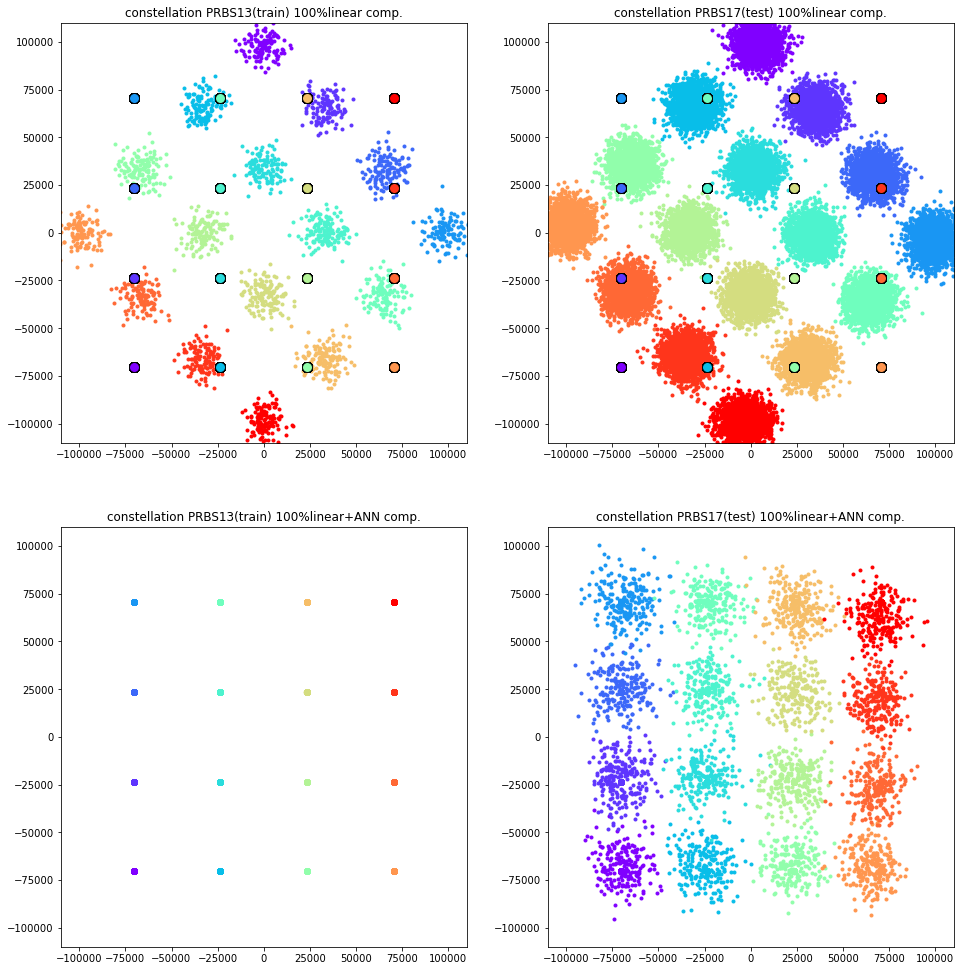

In [77]:
#可視化
annc0 = model(train_dataset[:][0]).detach().numpy()
annc0 = annc0 * std + mean
annc0 = annc0[:, 0] + annc0[:, 1] * 1j
y0 = train_dataset[:][1].detach().numpy()
y0 = y0 * std + mean
y0 = y0.astype(np.int32)
y0 = y0[:, 0] + y0[:, 1] * 1j
annc1 = model(val_dataset[:][0]).detach().numpy()
annc1 = annc1 * std + mean
annc1 = annc1[:, 0] + annc1[:, 1] * 1j
y1 = val_dataset[:][1].detach().numpy()
y1 = y1 * std + mean
y1 = y1.astype(np.int32)
y1 = y1[:, 0] + y1[:, 1] * 1j

lim = 110000
cm = plt.get_cmap('rainbow', 16)

seq0 = sgnl0.signal['x_0'][16::32]
seq1 = sgnl1.signal['x_0'][16::32]
symbol, inverse, counts = np.unique(seq0, return_inverse=True, return_counts=True)
symbol_int = symbol.real.astype(np.int32) + symbol.imag.astype(np.int32) * 1j

fig = plt.figure(figsize=(16, 17))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

for i in range(len(symbol)):
    ax1.plot(lc0[16::32][seq0 == symbol[i]].real, lc0[16::32][seq0 == symbol[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=str(counts[i]))
for i in range(len(symbol)):
    ax1.plot(sgnl0.signal['x_0'][16::32][seq0 == symbol[i]].real, sgnl0.signal['x_0'][16::32][seq0 == symbol[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]], markersize=10, markeredgewidth=1, markeredgecolor='black')
ax1.set_title('constellation PRBS13(train) 100%linear comp.')
ax1.set_xlim(-lim, lim)
ax1.set_ylim(-lim, lim)

for i in range(len(symbol)):
    ax2.plot(lc1[16::32][seq1 == symbol[i]].real, lc1[16::32][seq1 == symbol[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=str(counts[i]))
for i in range(len(symbol)):
    ax2.plot(sgnl1.signal['x_0'][16::32][seq1 == symbol[i]].real, sgnl1.signal['x_0'][16::32][seq1 == symbol[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]], markersize=10, markeredgewidth=1, markeredgecolor='black')
ax2.set_title('constellation PRBS17(test) 100%linear comp.')
ax2.set_xlim(-lim, lim)
ax2.set_ylim(-lim, lim)

for i in range(len(symbol)):
    ax3.plot(annc0[y0 == symbol_int[i]].real, annc0[y0 == symbol_int[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
for i in range(len(symbol)):
    ax3.plot(y0[y0 == symbol_int[i]].real, y0[y0 == symbol_int[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
ax3.set_title('constellation PRBS13(train) 100%linear+ANN comp.')
ax3.set_xlim(-lim, lim)
ax3.set_ylim(-lim, lim)


for i in range(len(symbol)):
    ax4.plot(annc1[y1 == symbol_int[i]].real, annc1[y1 == symbol_int[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
for i in range(len(symbol)):
    ax4.plot(y1[y1 == symbol_int[i]].real, y1[y1 == symbol_int[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
ax4.set_title('constellation PRBS17(test) 100%linear+ANN comp.')
ax4.set_xlim(-lim, lim)
ax4.set_ylim(-lim, lim);

In [74]:
annc0[y0 == symbol[i]]
print(symbol)

[-1.34164079-1.34164079j -1.34164079-0.4472136j  -1.34164079+0.4472136j
 -1.34164079+1.34164079j -0.4472136 -1.34164079j -0.4472136 -0.4472136j
 -0.4472136 +0.4472136j  -0.4472136 +1.34164079j  0.4472136 -1.34164079j
  0.4472136 -0.4472136j   0.4472136 +0.4472136j   0.4472136 +1.34164079j
  1.34164079-1.34164079j  1.34164079-0.4472136j   1.34164079+0.4472136j
  1.34164079+1.34164079j]


In [ ]:
#結果と条件を../data/params/ANN.csvに保存する
tap = 1
max_tap = 501
batch_size = 100
neuron = 300
epochs = 100
lr = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)

signal_type = 'image'

form = 'RZ16QAM'  # 変調方式
n = 32  # 1シンボルあたりのサンプリング数[/symbol]
equalize = False  # 各シンボル数を均等にするか
baudrate = 28  # ボーレート[GBaud]
PdBm = 1  # 平均入力光パワー[dBm]
Ledfa = 100  # EDFAスパン[km]
stepedfa = 30  # SSFMの繰り返し計算ステップ数
gamma = 1.4  # 非線形係数[/W/km]
D = 16  # 分散パラメータ[ps/nm/km]
Alpha = 0.16  # 伝送損失[dB/km]
NF = 4  # ASE雑音指数[dB]
Lmax = 500  # 伝送距離[km]
ase = True  # ASE雑音を考慮するか

if signal_type == 'prbs':
    N = 13  # PRBSの次数
    itr = 1  # PRBSの繰り返し回数
elif signal_type == 'random':
    seed = 1234  # 乱数シード
    bit_num = 10000  # ビット長を指定
elif signal_type == 'image':
    target_dir = 'train'
    step = 10  # =10 ---> (768, 1024) ---> (76, 102)
    image_number = [0, 1]
    ebtb = True  # 8B10Bを行うか

# prbs.csv or random.csv or image.csvをpandasで読み込む
t_df_dir = '../data/input/'
t_df = pd.read_csv(t_df_dir+signal_type+'.csv', index_col=0)

# if ANN.csv がある: pandasで読み込む if ANN.csvがない: 新しいDataFrameを作る
l_df_dir = '../data/params/ANN.csv'
if os.path.exists(l_df_dir):
    l_df = pd.read_csv(l_df_dir, index_col=0)
else:
    cols = ['tap', 'max_tap', 'batch_size', 'neuron', 'epochs', 'learning_rate', 'N', 'itr', 'seed', 'bit_num', 'target_dir', 'step', 'image_number', 'ebtb', 'form', 'n', 'equalize', 'baudrate', 'PdBm', 'Ledfa', 'stepedfa', 'gamma', 'D', 'Alpha', 'NF', 'Lmax', 'ase', 'params_path', 'train_samples']
    l_df = pd.DataFrame(index=[], columns=cols)
    l_df.to_csv(l_df_dir)

# 指定した学習条件と伝送条件
l_condition = 'tap=='+str(tap)+'&max_tap=='+str(max_tap)+'&batch_size=='+str(batch_size)+'&neuron=='+str(neuron)+'&learning_rate=='+str(lr)
t_condition = 'form=="'+str(form)+'"&n=='+str(n)+'&equalize=='+str(equalize)+'&baudrate=='+str(baudrate)+'&PdBm=='+str(PdBm)+'&Ledfa=='+str(Ledfa)+'&stepedfa=='+str(stepedfa)+'&\
                        gamma=='+str(gamma)+'&D=='+str(D)+'&Alpha=='+str(Alpha)+'&NF=='+str(NF)+'&ase=='+str(ase)
if signal_type == 'prbs':
    condition = 'N=='+str(N)+'&itr=='+str(itr)
    condition_list = [N, itr] + [None] * 6
elif signal_type == 'random':
    condition = 'seed=='+str(seed)+'&bit_num=='+str(bit_num)
    condition_list = [None] * 2 + [seed, bit_num] + [None] * 4
elif signal_type == 'image':
    condition = 'target_dir=="'+str(target_dir)+'"&step=='+str(step)+'&image_number=='+str(image_number[0])+'&ebtb=='+str(ebtb)
    condition_list = [None] * 4 + [target_dir, step, image_number, ebtb]

# prbs.csv or random.csv or image.csvにおいて、指定した伝送条件を見たす行を抜き出す
t_query = t_df.query(condition + '&' + t_condition)

# ANN.csvにおいて、指定した条件を満たす行だけqueryとして抜き出す
l_query = l_df.query(l_condition + '&' + condition + '&' + t_condition + '&Lmax=='+str(Lmax))

# 後で異なる値が代入されるもの以外をSeriesにしてしまう(epochs, params_path, train_samplesだけNone)
sr = pd.Series([tap, max_tap, batch_size, neuron, None, lr] + condition_list + [form, n, equalize, baudrate, PdBm, Ledfa, stepedfa, gamma, D, Alpha, NF, Lmax, ase, None, None], index=l_df.columns)
    
#if epochsを含む指定された条件を満たす結果がある: 何もしない
if len(l_query) > 0 and l_query['epochs'].max() >= epochs:
    print('指定された条件の学習結果はすでに存在します')
else:
    # if epochs以外の指定された条件を満たす結果がある: パラメータを読み込む if ない: 新しくモデルを作成する
    if len(l_query) > 0:
        index = l_query['epochs'].idxmax()
        trained_epochs = l_query['epochs'][index]
        model = ANN(input_dim=tap*2, output_dim=2, hidden_neuron=neuron).to(device)
        model.load_state_dict(torch.load(l_query['params_path'][index]))
    else:
        trained_epochs = 0
        model = ANN(input_dim=tap*2, output_dim=2, hidden_neuron=neuron).to(device)
    
    # if prbs.csv or random.csv or image.csvに指定した伝送条件がない or Lmax以外は満たすがLmaxだけ指定した条件未満: 何もしない if ある: 続ける
    if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
        print('指定された伝送条件の信号が存在しません')
    else:
        # 伝送信号を学習データに整形する
        sgnl_train = load_pickle(t_query.iloc[0]['data_path'])
        lc_train = sgnl_train.linear_compensation(Lmax, sgnl_train.signal['x_' + str(Lmax)])
        x_train, y_train = data_shaping(sgnl_train.signal['x_0'][n//2::n], lc_train[n//2::n], max_tap, tap)
        
        if signal_type == 'image' and len(image_number) > 1:
            for i in range(1, len(image_number)):
                condition = 'target_dir=="'+str(target_dir)+'"&step=='+str(step)+'&image_number=='+str(image_number[i])+'&ebtb=='+str(ebtb)
                t_query = t_df.query(condition + '&' + t_condition)
                if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
                    print('指定された伝送条件の信号が存在しません')
                    sys.exit()
                sgnl_train = load_pickle(t_query.iloc[0]['data_path'])
                lc_train = sgnl_train.linear_compensation(Lmax, sgnl_train.signal['x_' + str(Lmax)])
                x_train_tmp, y_train_tmp = data_shaping(sgnl_train.signal['x_0'][n//2::n], lc_train[n//2::n], max_tap, tap)
                x_train = np.concatenate([x_train, x_train_tmp])
                y_train = np.concatenate([y_train, y_train_tmp])
        
        train_samples = len(x_train)

        # 平均,標準偏差の計算
        mean = np.mean(x_train)
        std = np.std(x_train)

        # dataset, dataloaderの作成
        train_dataset = Dataset(x=x_train, y=y_train, mean=mean, std=std)
        train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        dataloaders_dict = {'train': train_dataloader}

        # 損失関数, オプティマイザの作成
        criterion = nn.MSELoss()
        optimizer = optim.Adam(params=model.parameters(), lr=lr)

        # モデルのトレーニング(50epochsずつ学習し、50epochsずつパラメータを保存する)
        for i in range((epochs - trained_epochs) // 50):
            model = train_model(device=device, model=model, dataloaders_dict=dataloaders_dict, criterion=criterion, optimizer=optimizer, epochs=50, epochs_section=[trained_epochs+i*50, epochs])

            # 学習済みパラメータを保存し、ANN.csvに保存先を記入する
            l_df = pd.read_csv(l_df_dir, index_col=0)
            params_path = '../data/params/ANN/params_' + str(len(l_df)).zfill(10) + '.pth'
            torch.save(model.state_dict(), params_path)
            sr[4] = trained_epochs + (i + 1) * 50
            sr[-2] = params_path
            sr[-1] = train_samples
            l_df = l_df.append(sr, ignore_index=True)
            l_df.to_csv(l_df_dir)

l_df